# Six Southern Labor Markets #6
### Unemployment type and duration

February 19, 2019

Brian Dew, @bd_econ

-----

For the combined years 2016, 2017, and 2018, look at why people are unemployed and how this compares to national average. Then look at how unemployment duration is divided between short- (<5 weeks), medium- (5-26 weeks), and long-term (27+ weeks) unemployment.

Areas:

- Chattanooga
- Knoxville
- Greenville
- Asheville
- Kingsport
- Huntsville
- US total

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
areas = [('Chattanooga-Cleveland-Dalton, TN-GA', 'CSA', [174]),
         ('Greenville-Anderson-Spartanburg, SC', 'CSA', [273]),
         ('Asheville, NC', 'CBSA', [11700]),
         ('Johnson City-Kingsport-Bristol, TN-VA', 'CSA', [304]),
         ('Huntsville, AL', 'CBSA', [26620]),
         ('Knoxville, TN', 'CBSA', [28940])]

area_names = [area[0] for area in areas]

In [3]:
csa = [area[2][0] for area in areas if area[1] == 'CSA']
cbsa = [area[2][0] for area in areas if area[1] == 'CBSA']
grps = [('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

# Unemployment type

In [4]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'BASICWGT', 'LFS', 'UNEMPTYPE', 'UNEMPDUR']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2016, 2017, 2018]])

In [10]:
# Collect results for total, men, women in each area
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('AGE >= 16')
    u = data.groupby('UNEMPTYPE').BASICWGT.sum()
    lf = data[data['LFS'] != 'NILF'].BASICWGT.sum()
    s = ((u / lf) * 100)
    for idx, val in s.iteritems():
        results.at[group[0], idx] = val 
        
results = results.drop('nan', axis=1)
results['Total'] = results.sum(axis=1)

#### Graph results

In [ ]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

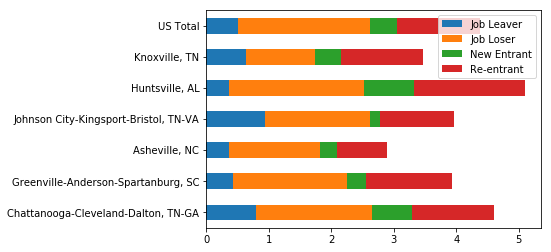

In [13]:
results.drop('Total', axis=1).plot(kind='barh', stacked=True)